In [1]:
%pylab inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/tw/zmm3b0k97wbfj0cl53y3w2nm0000gn/T/ipykernel_63347/395611636.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [79]:
import os
from scipy.interpolate import CubicSpline


In [178]:
t_array=evo[:,0].tolist()
Ric_array=evo[:,14].tolist()
Buoy_x=evo[:,1].tolist()

In [179]:
for i in range(1,len(t_array)):
    if Ric_array[i-1]==0.0 and Ric_array[i]>0.0:
        start_ind=i
f_Ric_t=CubicSpline(t_array[start_ind:],Ric_array[start_ind:])
f_dRicdt=f_Ric_t.derivative()
dRicdt=Ric_array.copy()
dRicdt[start_ind:]=f_dRicdt(t_array[start_ind:])
log10_dRicdt=dRicdt.copy()
log10_dRicdt_hat=dRicdt.copy()
log10_dRicdt[start_ind:]=np.log10(dRicdt[start_ind:])
log10_dRicdt_hat[start_ind:]=savgol_filter(log10_dRicdt[start_ind:], window_length=99,polyorder=9) 
for i in range(len(t_array)):
    Buoy_x[i]=Buoy_x[i]*10.0**dRicdt_hat[i]

In [144]:
CMF_list=np.linspace(0.1*100.0,0.8*100.0,8)
Mpl_list=np.zeros(11)
Mpl_list[0]=1.0
Mpl_list[1]=1.25
Mpl_list[2]=1.5
Mpl_list[3]=2.0
Mpl_list[4]=2.5
Mpl_list[5]=3.0
Mpl_list[6]=4.0
Mpl_list[7]=5.0
Mpl_list[8]=6.0
Mpl_list[9]=7.0
Mpl_list[10]=8.0
foldername=[]
for i in range(len(Mpl_list)):
    foldername_CMF=[]
    if Mpl_list[i]%1.0==0.0:
        Mpl_part=str(int(Mpl_list[i]))+'ME_'
    elif Mpl_list[i]%1.0==0.5:
        Mpl_part=str(int(Mpl_list[i]))+'hME_'
    else:
        Mpl_part=str(int(Mpl_list[i]))+'Q1ME_'
    print(Mpl_part)
    for j in range(len(CMF_list)):
        foldername_CMF.append(Mpl_part+str(int(CMF_list[j]))+'CMF/')
    foldername.append(foldername_CMF)
foldername[0][-1]='1ME_75CMF/'

1ME_
1Q1ME_
1hME_
2ME_
2hME_
3ME_
4ME_
5ME_
6ME_
7ME_
8ME_


In [157]:
np.savetxt('EoS/Guess_initial/Mpl_grid.txt',np.transpose([CMF_list]))

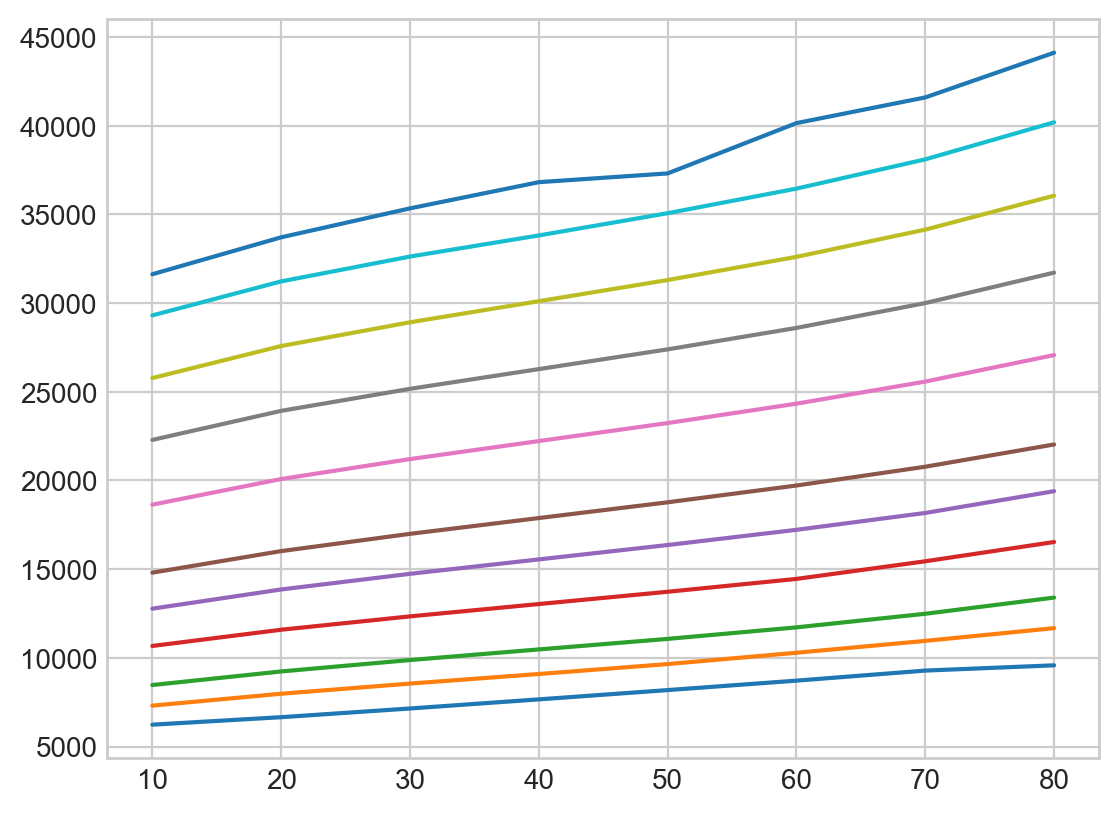

In [154]:
for i in range(len(Tc)):
    plot(CMF_list,Tc[i])

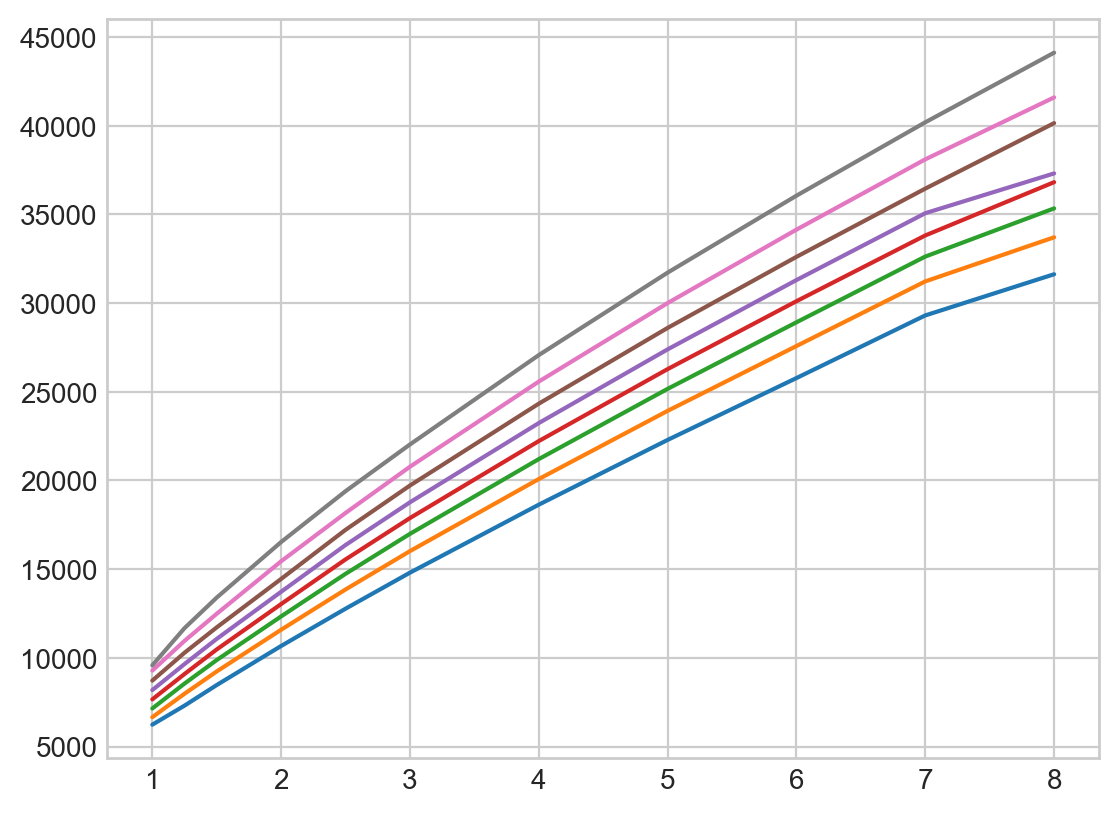

In [155]:
for i in range(len(Tc[0])):
    plot(Mpl_list,Tc[:,i])

In [40]:
save_t=[1.0]
for i in range(1,182):
    if save_t[i-1]<5000.0:
        save_t.append(save_t[i-1]+80.0)
    elif save_t[i-1]<1e8 and save_t[i-1]>=5000.0:
        save_t.append(save_t[i-1]+int(save_t[i-1]/3.0))
    elif save_t[i-1]>=1e8 and save_t[i-1]<1e9:
        save_t.append(save_t[i-1]+int(save_t[i-1]/10.0))
    else:
        save_t.append(save_t[i-1]+int(save_t[i-1]/25.0))

In [47]:
save_t_title=save_t.copy()
t_title=[]
for i in range(len(save_t)):
    if save_t[i]<100.0 and save_t[i]>1.0:
        save_t_title[i]=save_t_title[i]-1.0
    elif save_t[i]>=100.0 and save_t[i]<10000.0:
        round_value=round(save_t[i], -2)
        save_t_title[i]=round_value
    else:
        round_value=round(save_t[i], -len(str(int(save_t[i])))+2)
        save_t_title[i]=round_value

    if save_t_title[i]<1000.0:
        if save_t[i]==1.0:
            t_title.append('time: '+str(int(save_t_title[i]))+' year')
        t_title.append('time: '+str(int(save_t_title[i]))+' years')
    elif save_t_title[i]>=1000.0 and save_t_title[i]<1000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000.0)+' kyr')
    elif save_t_title[i]>=1000000.0 and save_t_title[i]<1000000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000000.0)+' Myr')
    elif save_t_title[i]>=1000000000.0 and save_t_title[i]<1000000000000.0:
        t_title.append('time: '+str((save_t_title[i])/1000000000.0)+' Gyr')
    st=t_title[i]
    if len(t_title[i])==11:
        t_title[i]='  '+st
    elif len(t_title[i])==12:
        t_title[i]=' '+st

In [38]:
load_file=np.loadtxt('input.txt')
results_foldername='results_Mpl'+str(load_file[0])+'_CMF'+str(load_file[1])+'_time'+str(load_file[2])+'_Qrad'+str(load_file[3])+'_'+str(load_file[4])+'_'+str(load_file[5])+'_'+str(load_file[6])+'_Teq'+str(load_file[8])


mass_profile=np.loadtxt(results_foldername+'/profile/t0/structure0.txt')
mass=mass_profile[:,8]

s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[0]))+'.txt')
T_max=max(s[:,4])#+max(s[:,4])*0.01
R_max=max(s[:,0])#+max(s[:,0])*0.01
rho_min=min(s[:,2])
Fconv_max=(max(s[:,7][5:-2])*5.0#+max(s[:,7][5:-2])*0.01)
s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[-1]))+'.txt')
T_min=min(s[:,4])*0.9#-50.0
P_max=(max(s[:,1])/1e9)*1.05#+max(s[:,1])/1e11
P_min=-1.0
rho_max=max(s[:,2])+max(s[:,2])*0.01
g_max=max(s[:,3])+max(s[:,3])*0.01
eta_max=max(s[:,12])+max(s[:,12])*0.01
s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[1]))+'.txt')
Rem_max=max(s[:,11])*5.0#+max(s[:,11])*0.01
vconv_max=max(s[:,10][5:-2])*5.0#+max(s[:,10][5:-2])*0.01


In [42]:
s0=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[0]))+'.txt')
sE=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[-1]))+'.txt')

In [216]:
def f_axis_max_min(v_min,v_max,axis_scale):
    if axis_scale=='log':
        v_max=np.log10(v_max)
        v_min=np.log10(v_min)
        dv=np.abs(v_max-v_min)/10.0
        v_max=10.0**(v_max+dv)
        v_min=10.0**(v_min-dv)
    else:
        dv=np.abs(v_max-v_min)/10.0
        v_max=v_max+dv
        v_min=v_min-dv
    return v_min,v_max

In [210]:
s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[0]))+'.txt')
T_max=max(s[:,4])#+max(s[:,4])*0.01
R_max=max(s[:,0])#+max(s[:,0])*0.01
Fconv_max=max(s[:,7][5:-2])#+max(s[:,7][5:-2])*0.01
eta_min=min(s[:,12]+1e-7)
g_min=min(s[:,3])
rho_min=min(s[:,2])

s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[-1]))+'.txt')
T_min=min(s[:,4])#-50.0
P_max=max(s[:,1])/1e9#+max(s[:,1])/1e11
P_min=1e5/1e9
rho_max=max(s[:,2])#+max(s[:,2])*0.01
g_max=max(s[:,3])#+max(s[:,3])*0.01
vconv_min=min(s[:,10][5:-2]+1e-7)
eta_max=max(s[:,12])#+max(s[:,12])*0.01
Rem_min=min(s[:,11]+1e-3)
R_min=min(s[:,0])
Fconv_min=min(s[:,7][5:-2]+1e-7)

s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[1]))+'.txt')
Rem_max=max(s[:,11])#+max(s[:,11])*0.01
vconv_max=max(s[:,10][5:-2])#+max(s[:,10][5:-2])*0.01

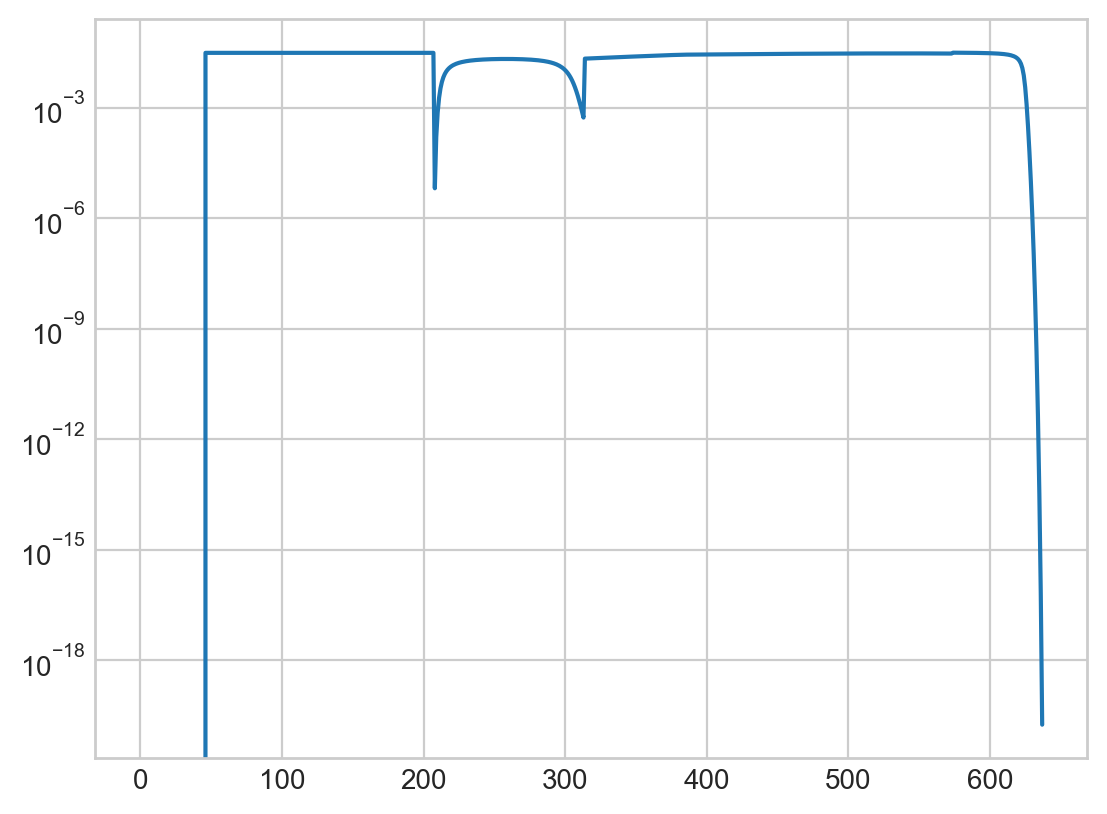

In [255]:
s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[-1]))+'.txt')
plot(s[:,7][:-2])
plt.yscale('log')
#plot(s[:,8])

In [258]:
s[:,7][40:50]
solid_core_index=0
for j in range(int(core_zone-1)):
    if s[:,8][j]>0 and s[:,8][j+1]==0.0:
        solid_core_index=j
print(solid_core_index)

45


In [259]:
s[:,7][45:50]

array([0.        , 0.03103467, 0.03103467, 0.03103467, 0.03103467])

In [248]:
for i in range(len(s[:,8])):
    if s[:,8][i]==0:
        print(i)

46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207


In [250]:
s[:,11][206:210]

array([15581.64400925, 15633.7000909 ,     0.        ,     0.        ])

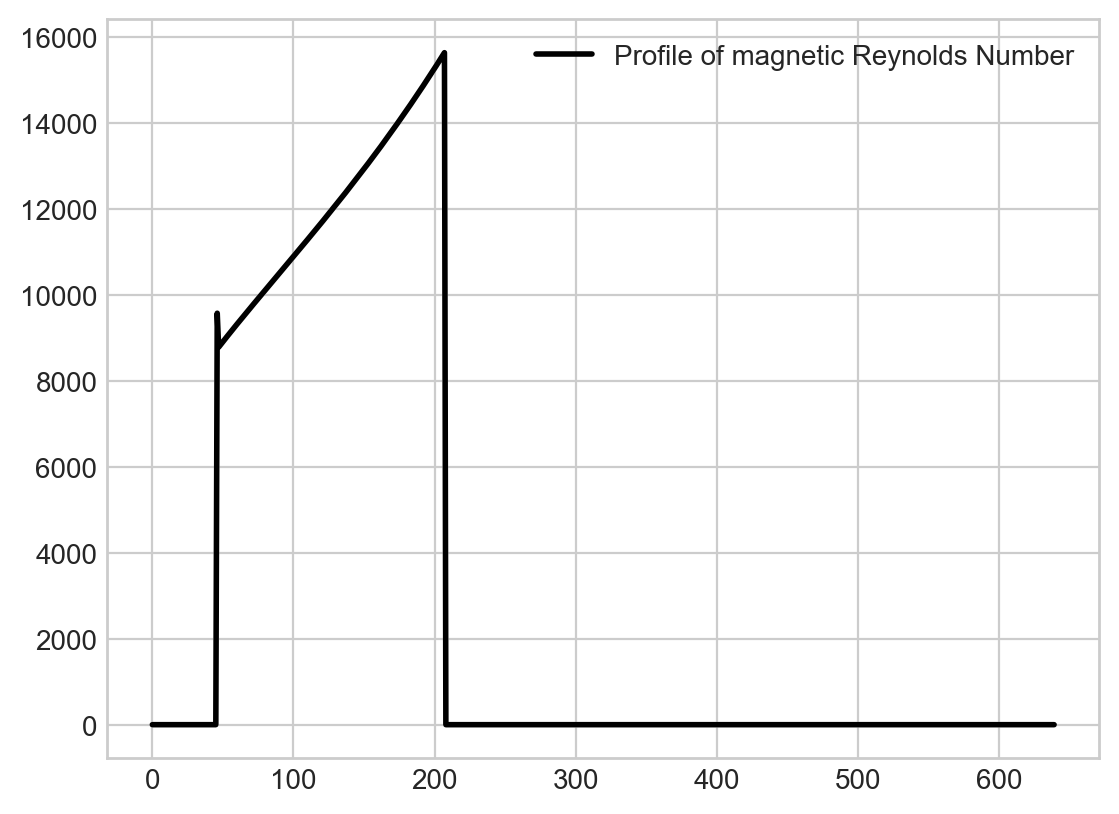

In [251]:
plot(s[:,11],color='white',linewidth=2.0)
plot(s[:,11],color='black',linewidth=2.0,label='Profile of magnetic Reynolds Number')
plt.legend()

In [237]:
previous=np.loadtxt(results_foldername+'/profile/t0/previous0.txt')
core_zone=previous[-2]
print(core_zone)


208.0



In [243]:
for i in range(int(core_zone-1)):
    if s[:,8][i]>0 and s[:,8][i+1]==0.0:
        print(i)

45


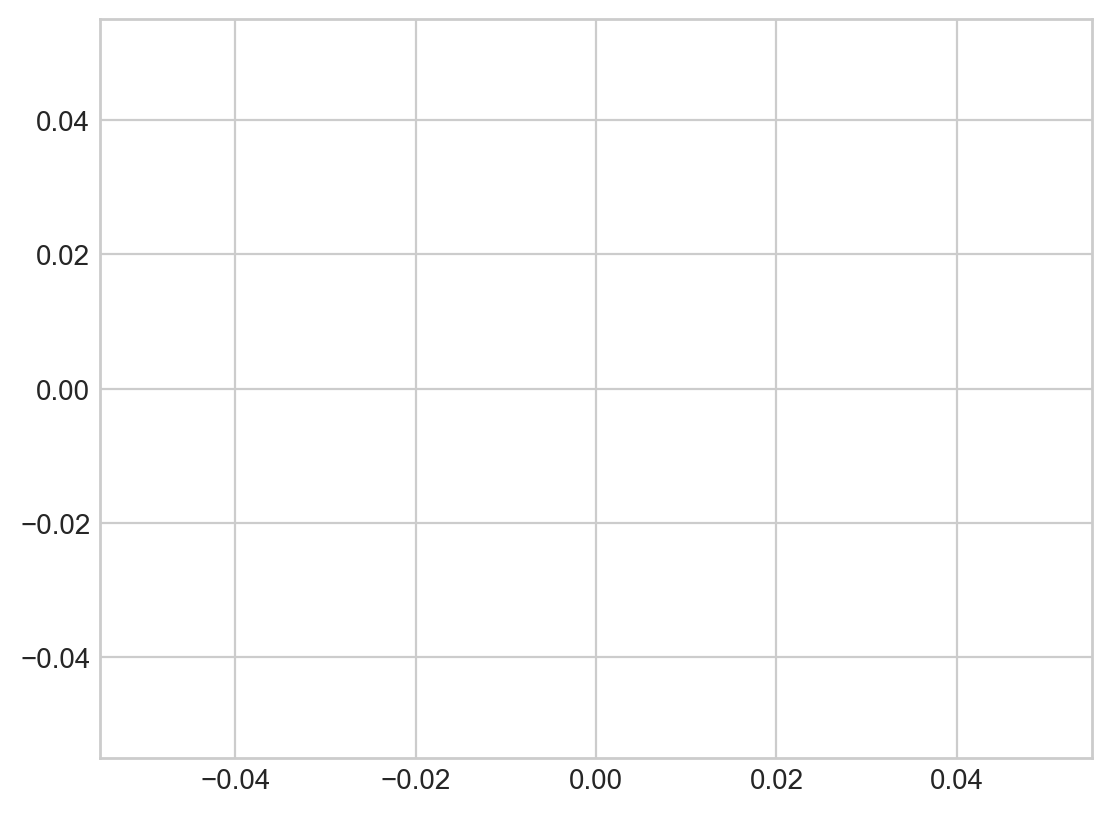

In [244]:
plot(s[:,8][:0],linestyle='dashed',color='royalblue',linewidth=1.5,label='Core conductive heat flux')

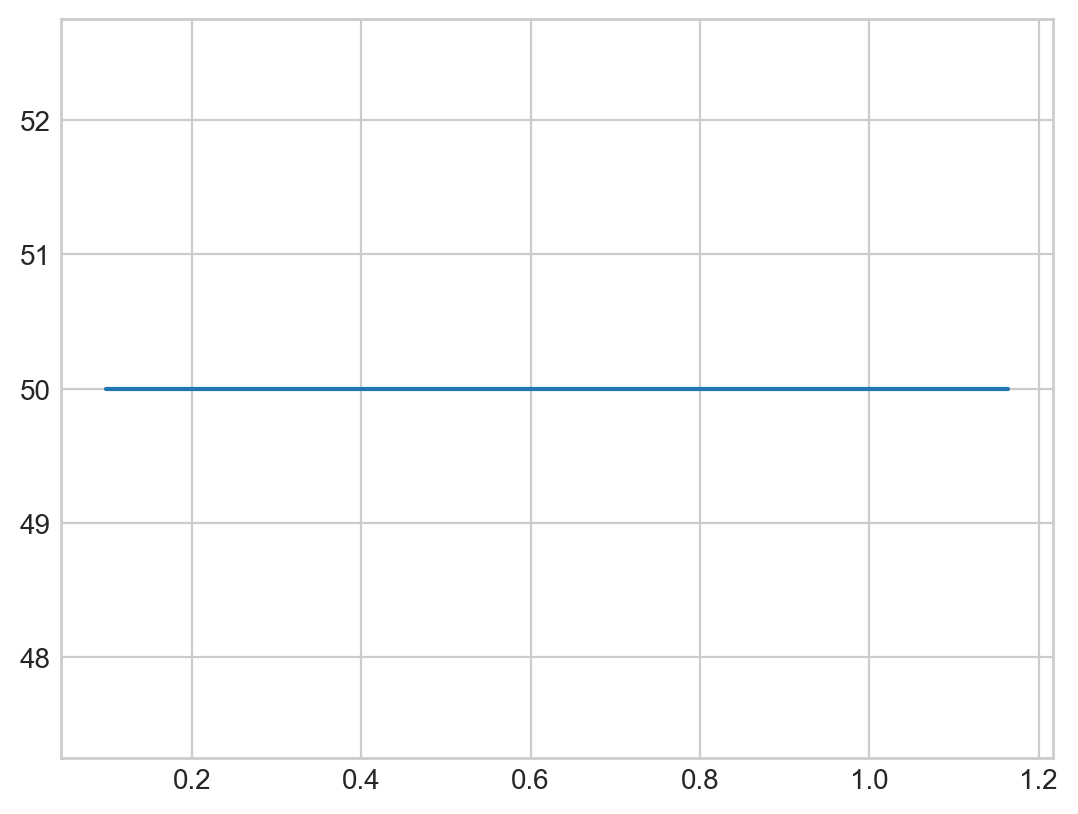

In [219]:
threshold_Bfield=np.ones(len(s[:,0]))*50.0
plt.plot(s[:,0]/6371000.0,threshold_Bfield)

In [211]:
print(log10(Rem_min),log10(Rem_max))
print(log10(vconv_min),log10(vconv_max))
print(log10(Fconv_min),log10(Fconv_max))
print(log10(eta_min),log10(eta_max))
print(g_min,g_max)

-3.0 6.148838431271439
-7.0 0.055294097409742046
-7.0 6.1470895382238915
-7.0 37.81819664818557
2.386888010361425 13.242220218900355


In [218]:
axis_scale='linear'
T_min,T_max=f_axis_max_min(T_min,T_max,axis_scale)
print(T_min)
print(T_max)

-689.0750503233457
10896.164461581271


In [209]:
eta_min

0.0

Text(0.5, 0, 'Mass ($M_{\\oplus}$)')

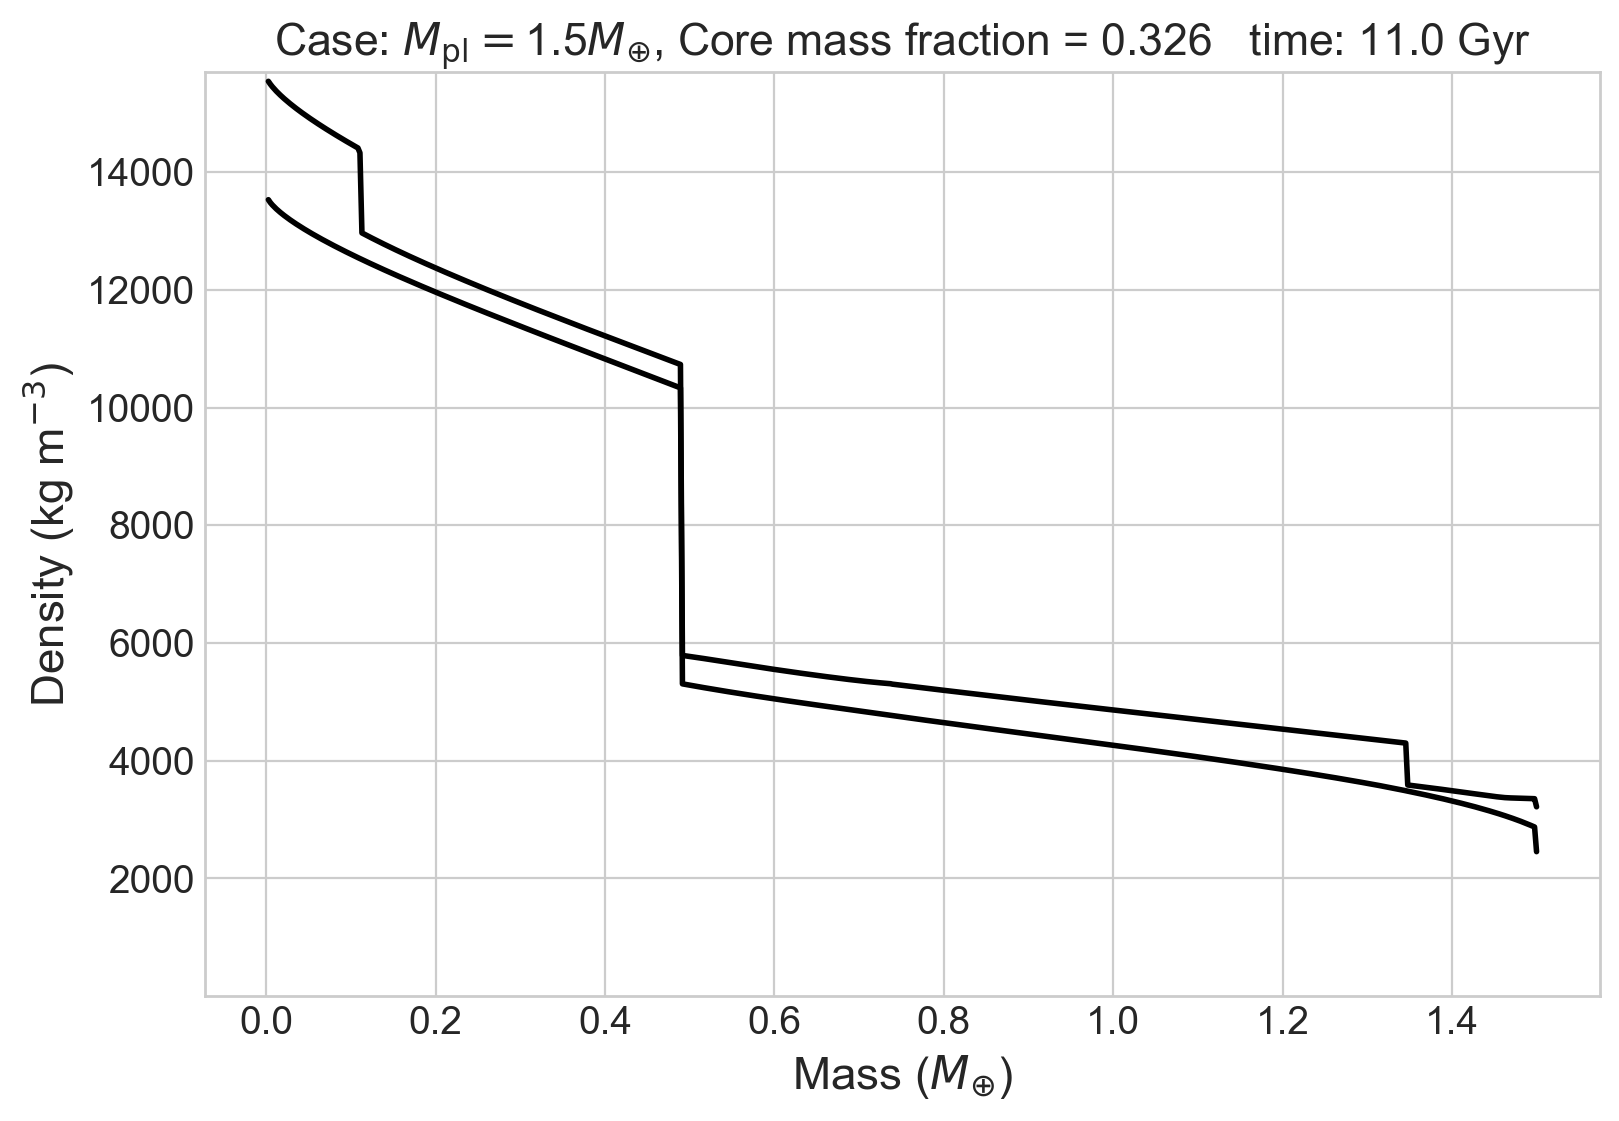

In [49]:
plt.figure(figsize=(9,6))
axis_scale='linear'
plt.plot(mass/5.972e24,s0[:,2],color='black',linewidth=2.0)
plt.plot(mass/5.972e24,sE[:,2],color='black',linewidth=2.0)
y_ni
plt.ylim(0.01,rho_max)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Case: '+r'$M_{\mathrm{pl}}= $'+str(load_file[0])+r'$ M_{\oplus}$, Core mass fraction = '+str(load_file[1])+'   '+t_title[i] ,fontsize=16)
plt.ylabel(r'Density (kg m$^{-3}$)',fontsize=16.5)
plt.xlabel(r'Mass ($M_{\oplus}$)',fontsize=16.5)


In [183]:
evo=np.loadtxt(results_foldername+'/evolution_old.txt')

Text(0.5, 1.0, '$M_{\\mathrm{pl}}= $1.5$ M_{\\oplus}$, Core mass fraction = 0.326')

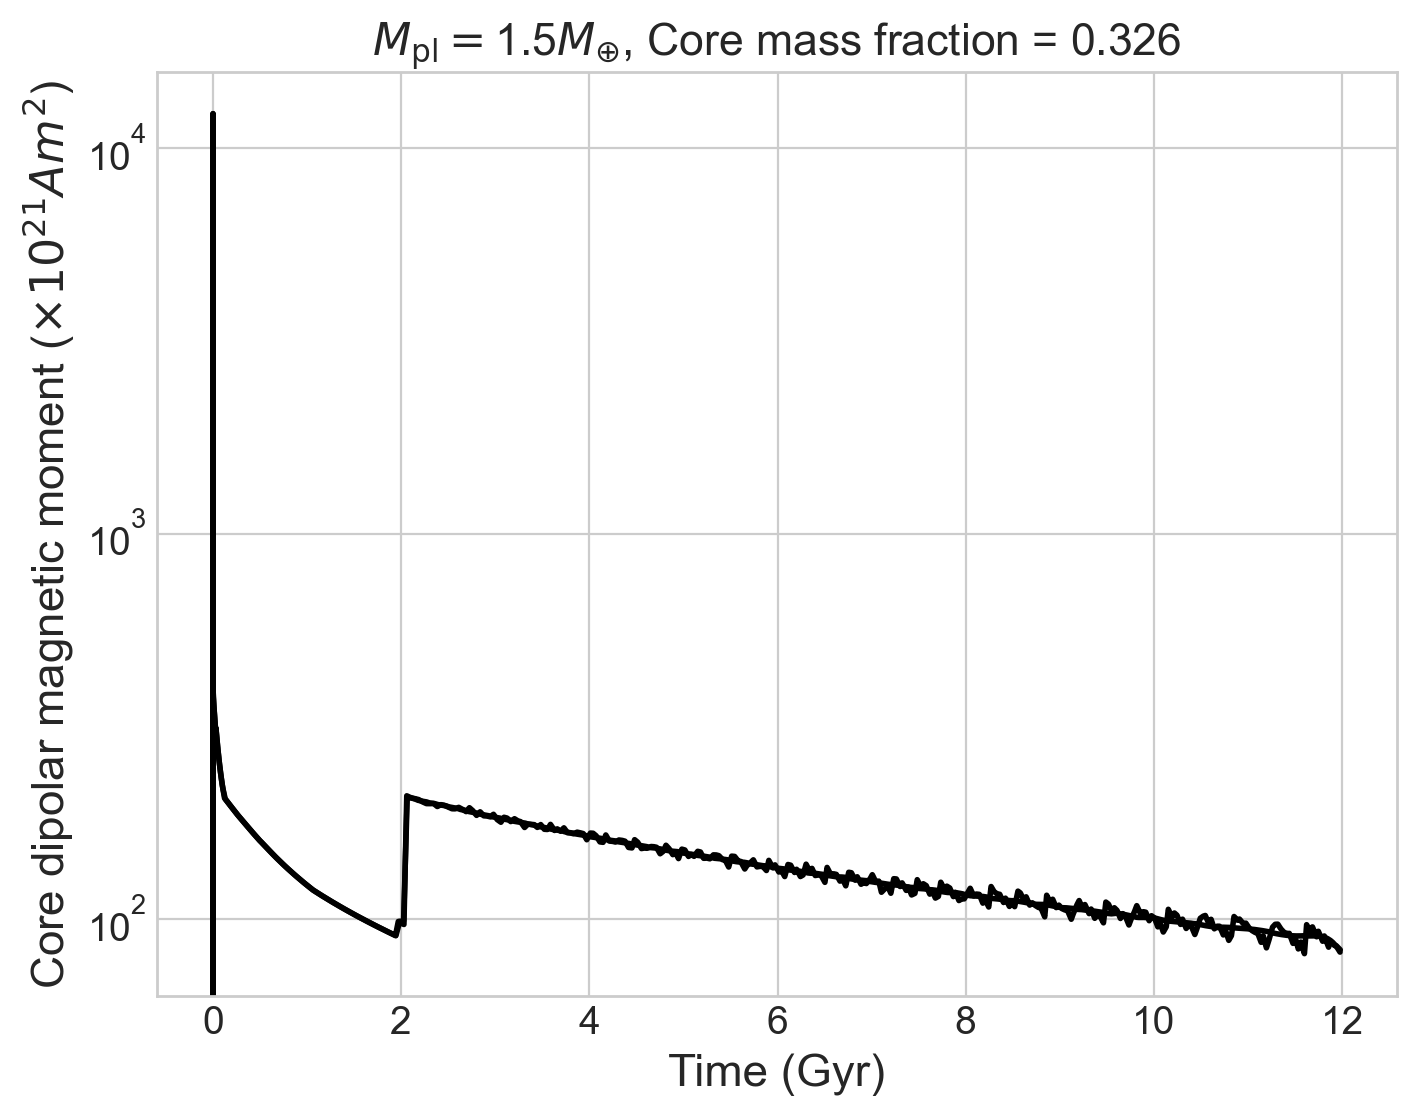

In [184]:
plt.figure(figsize=(8,6))
plt.plot(evo[:,0]/1e9/86400.0/365.0,evo[:,22]/1e21,color='black',linewidth=2.0)
plt.plot(evp[:,0]/1e9/86400.0/365.0,evp[:,22]/1e21,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.yscale('log')
plt.ylabel(r'Core dipolar magnetic moment ($\times 10^{21} Am^2$)',fontsize=16.5)
plt.xlabel('Time (Gyr)',fontsize=16.5)
plt.title(r'$M_{\mathrm{pl}}= $'+str(load_file[0])+r'$ M_{\oplus}$, Core mass fraction = '+str(load_file[1]) ,fontsize=16)

In [147]:
from scipy.signal import savgol_filter

# Sample data
x = np.array([1, 2, 3, 4, 5, 4, 3, 2, 1])

# Apply the filter
y = savgol_filter(x, window_length=5, polyorder=2) 

print(y)


[1.         2.         3.         4.17142857 4.65714286 4.17142857
 3.         2.         1.        ]


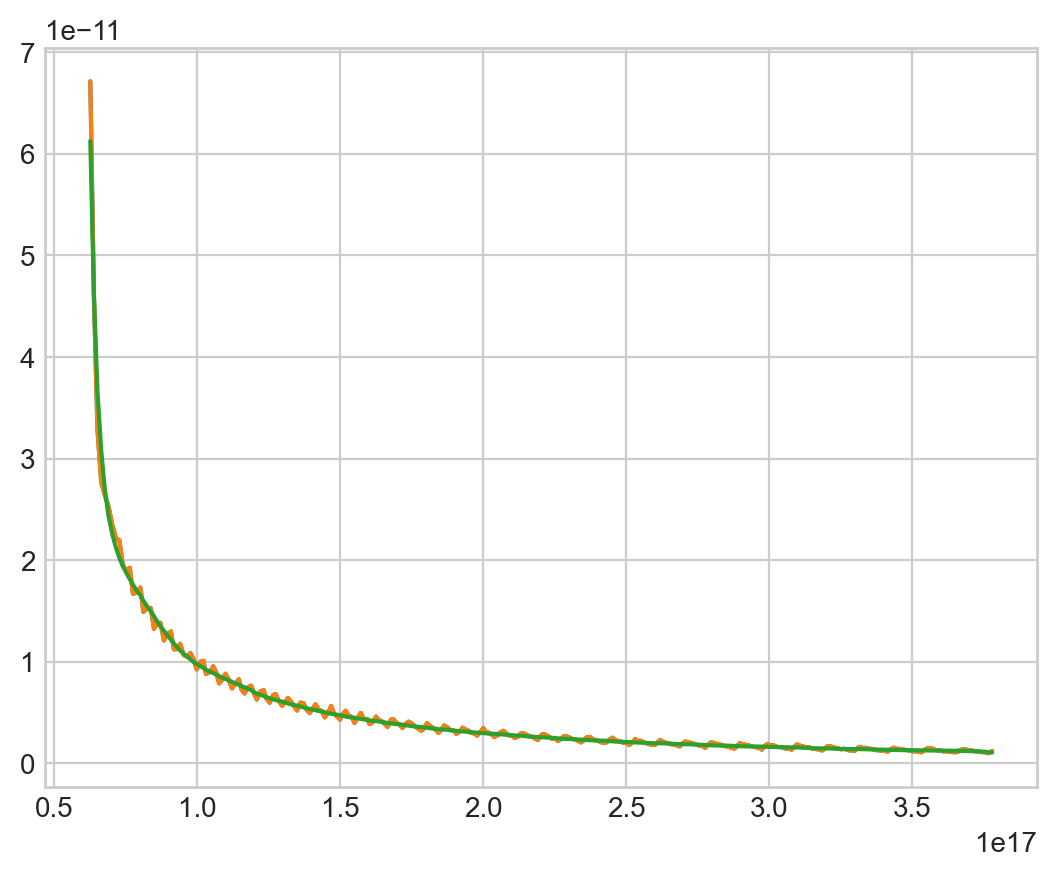

In [169]:
#plt.yscale('log')
Ric_t=CubicSpline(evo[:,0][start_ind:].tolist(),evo[:,14][start_ind:].tolist())
dRicdt=Ric_t.derivative()
plot(evo[:,0][start_ind:],dRicdt(evo[:,0][start_ind:]))
y=np.log10((dRicdt(evo[:,0][start_ind:])).tolist())
y_hat=savgol_filter(y.tolist(), window_length=99,polyorder=9) 
plot(evo[:,0][start_ind:],10.0**y)
plot(evo[:,0][start_ind:],10.0**y_hat)

In [171]:
Ric

array([      0.        ,       0.        ,       0.        , ...,
       2241998.44089285, 2242648.1914787 , 2244024.6891484 ])

In [252]:
## I use the next two cells to figure out how to speed up plotting.

import matplotlib.style as mplstyle
import time

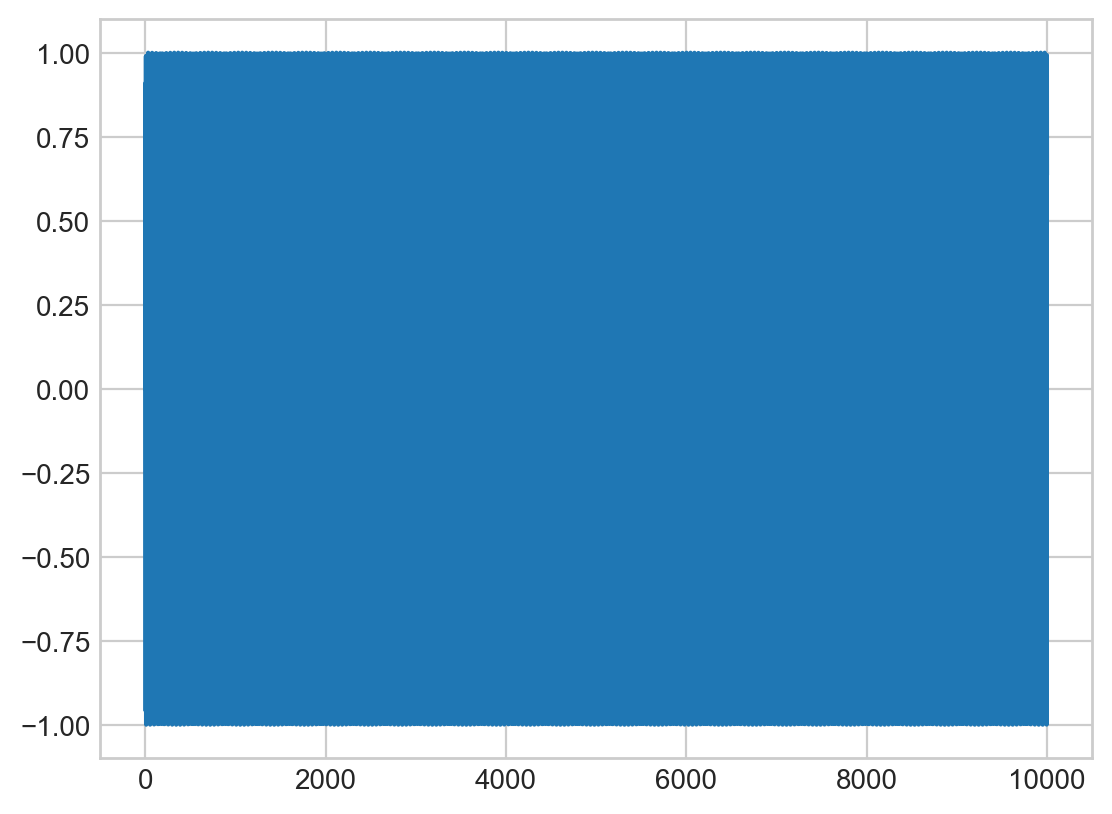

In [250]:
x = np.arange(0, 10000, 1)
y = np.sin(x)

while i
# Plot the data
plt.plot(x, y)


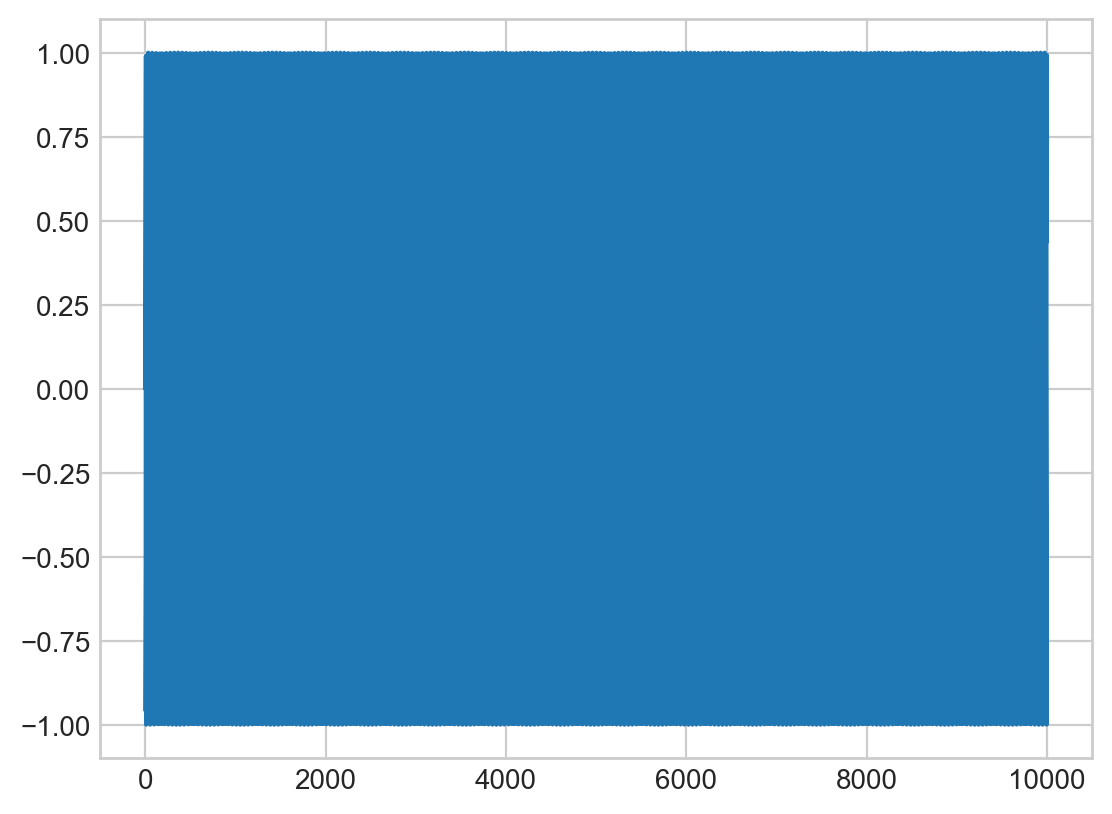

In [251]:
mplstyle.use('fast')
plt.plot(x, y)

In [4]:
evo=np.loadtxt('results/evolution.txt')
# index  variable  #### everything is in SI units
# 0       t
# 1       dt
# 2       average mantle specific entropy
# 3       average mantle temperature
# 4       average core temperature 
# 5       surface temperature
# 6       core mantle boundary (CMB) temperature
# 7       surface heat flux
# 8       CMB flux
# 9       Conductive flux along core adiabat (threshold flux for thermal convection in liquid core)
# 10      Planet radius
# 11      Core radius
# 12      Central pressure
# 13      CMB pressure

## pick values for i_x and i_y in the following boxes to set x and y-axis to plot thermal history of the planet

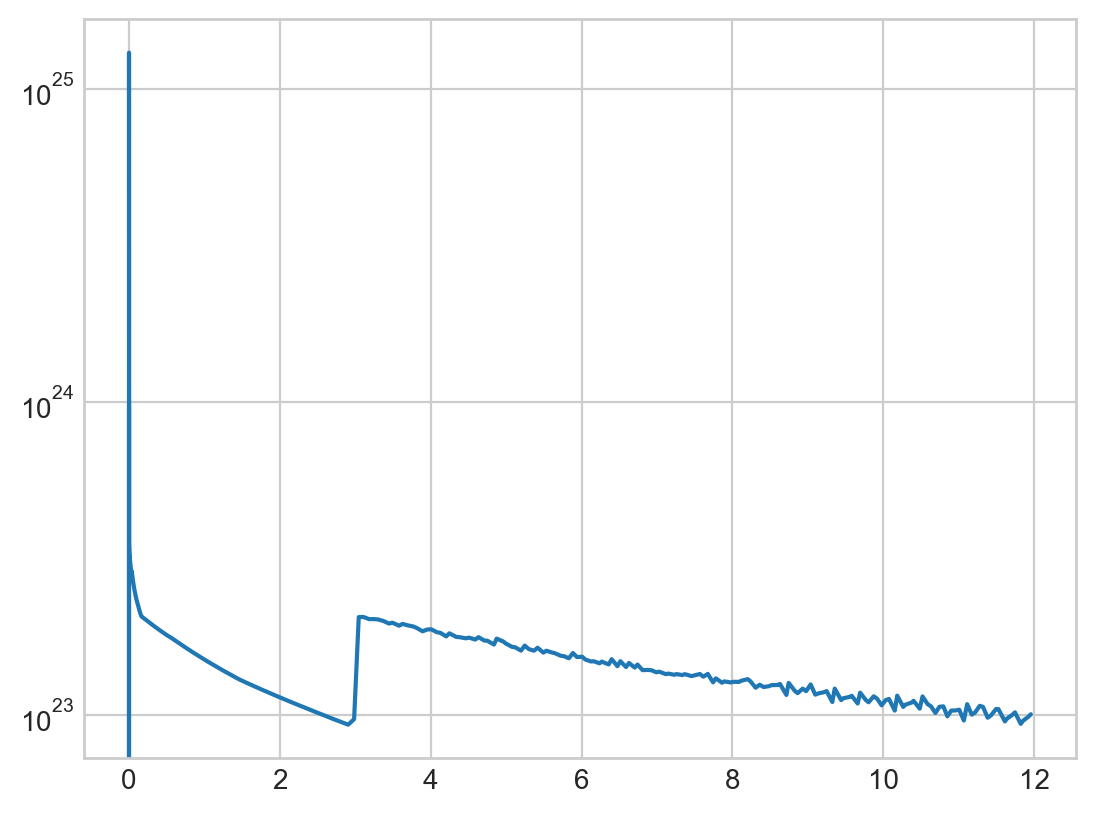

In [6]:
i_x=0
i_y=-1
plt.yscale('log')
plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y])

Text(0.5, 0, 'Gyr')

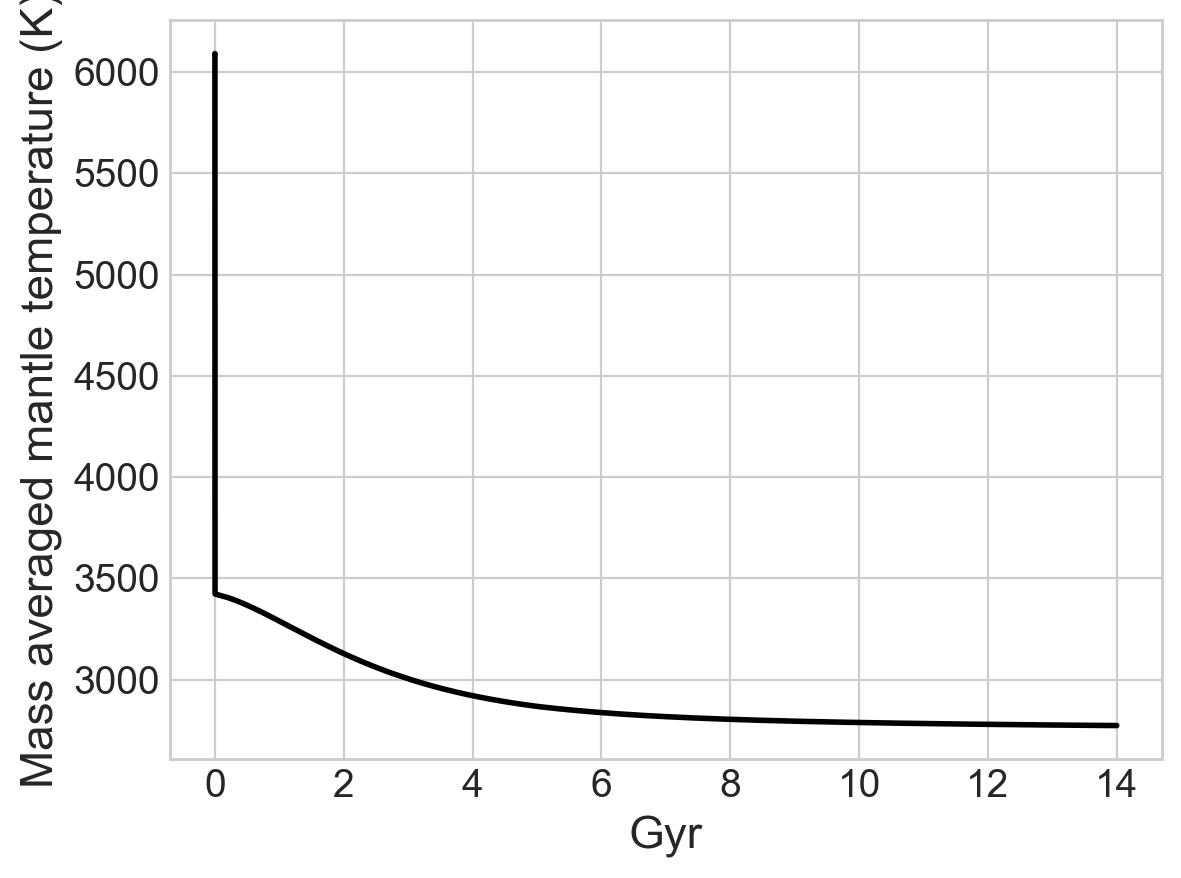

In [6]:
i_x=0
i_y=3
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Mass averaged mantle temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

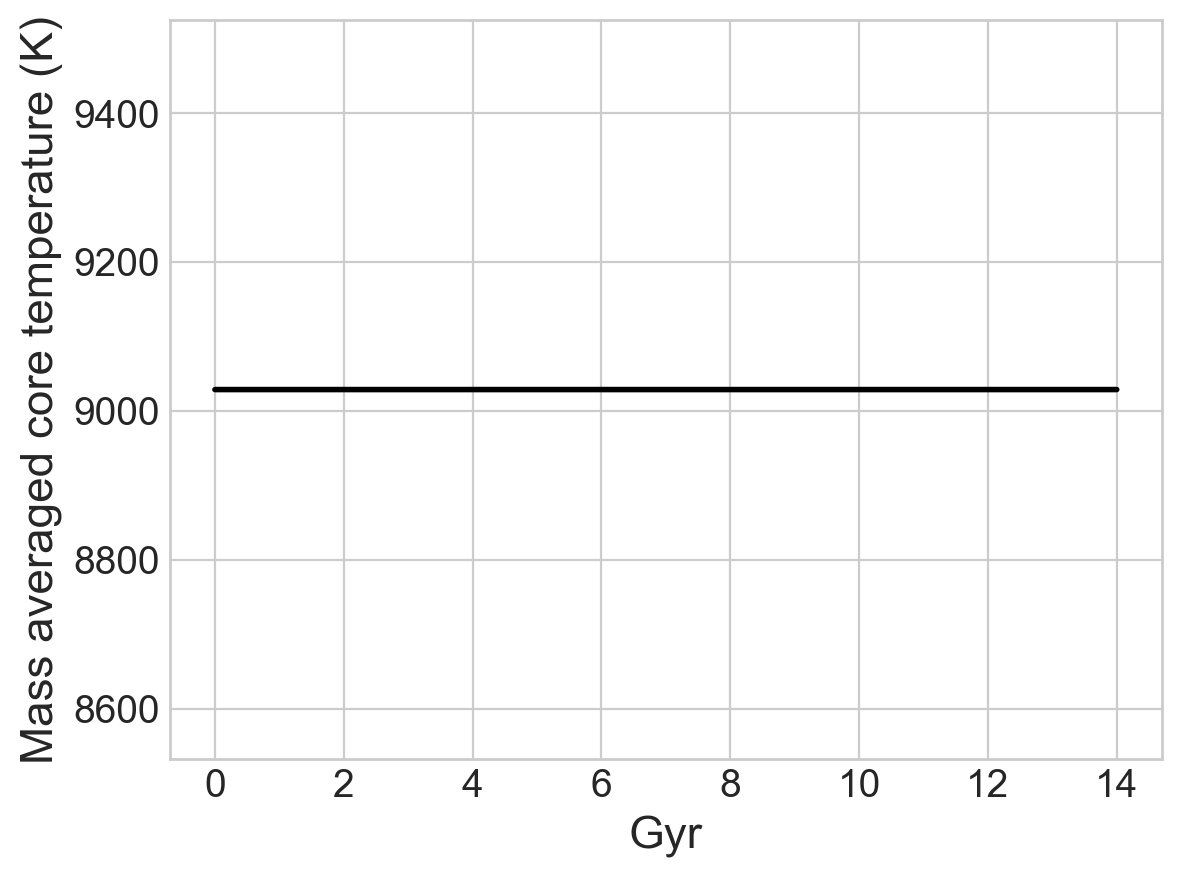

In [7]:
i_x=0
i_y=4
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Mass averaged core temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

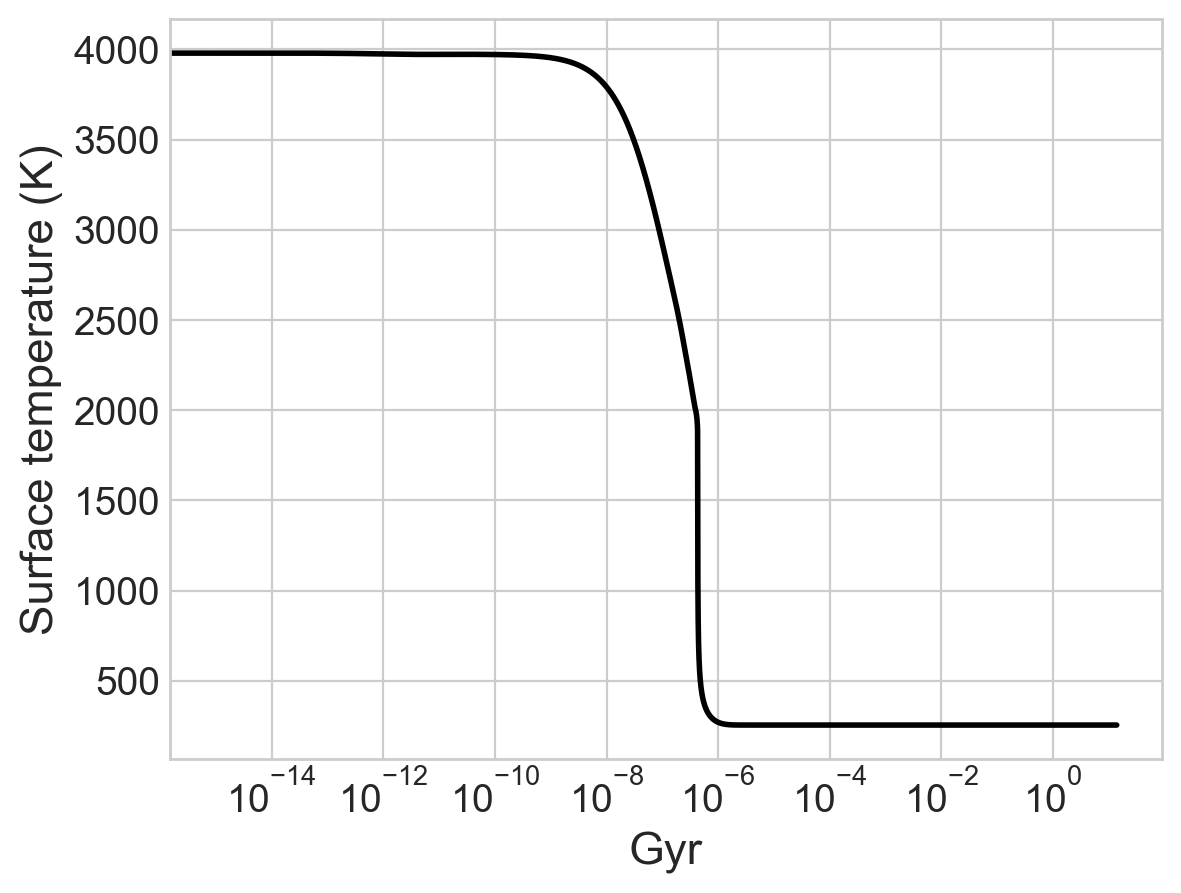

In [48]:
i_x=0
i_y=5
plt.xscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Surface temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

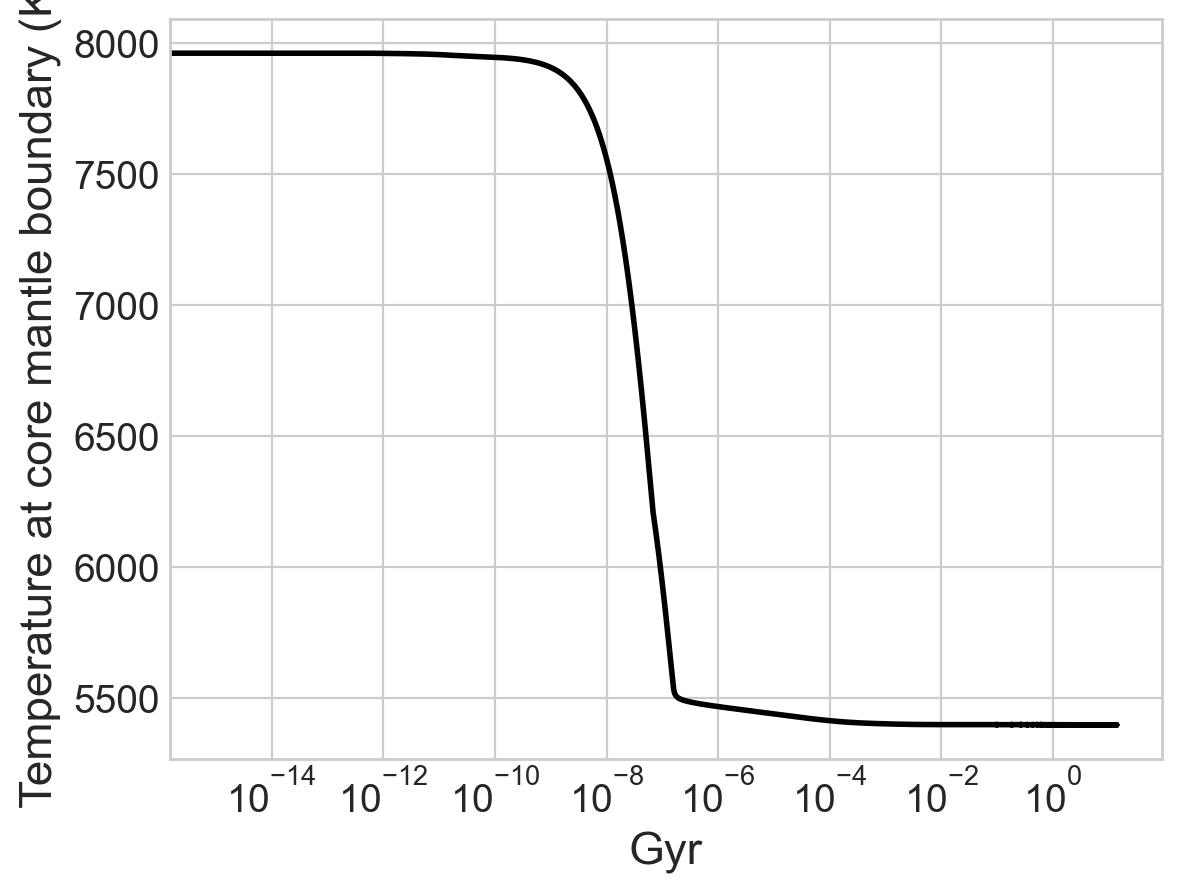

In [12]:
i_x=0
i_y=6
plt.xscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Temperature at core mantle boundary (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

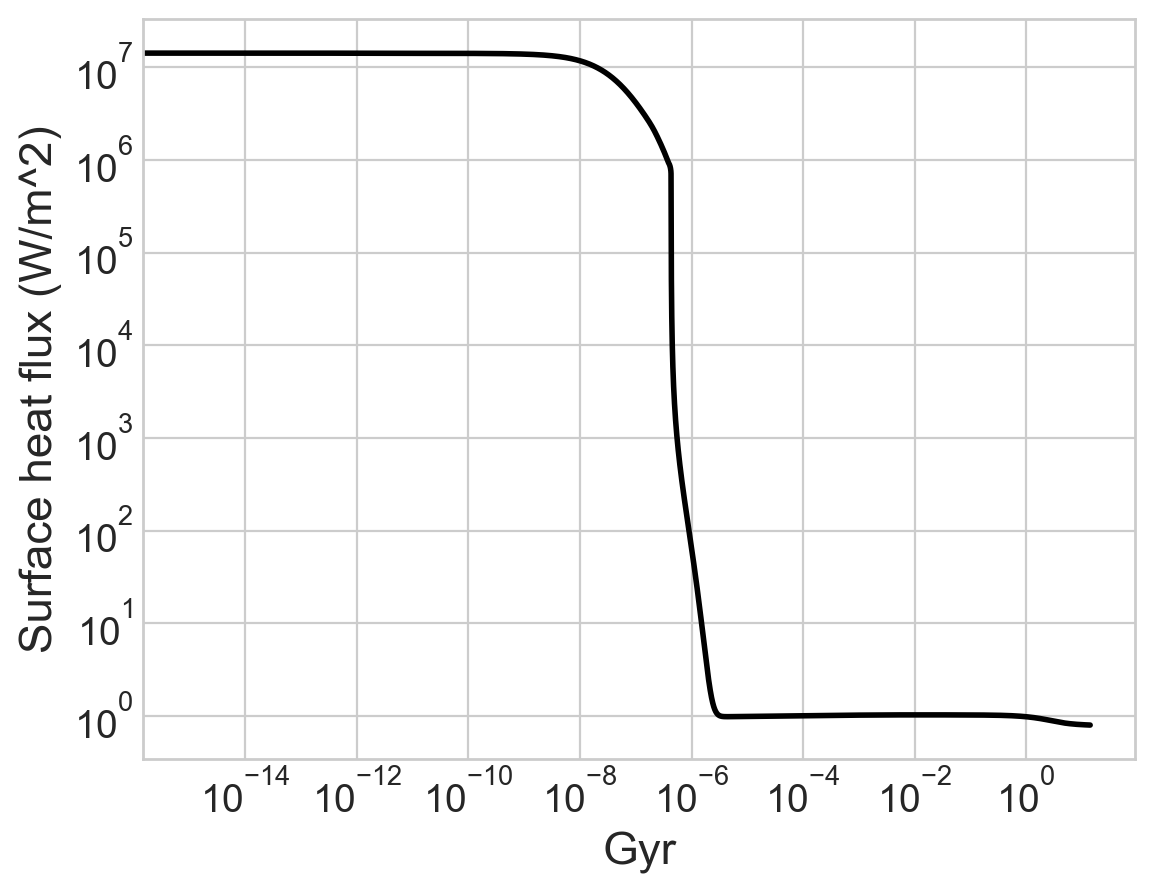

In [16]:
i_x=0
i_y=7
plt.xscale('log')
plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Surface heat flux (W/m^2)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

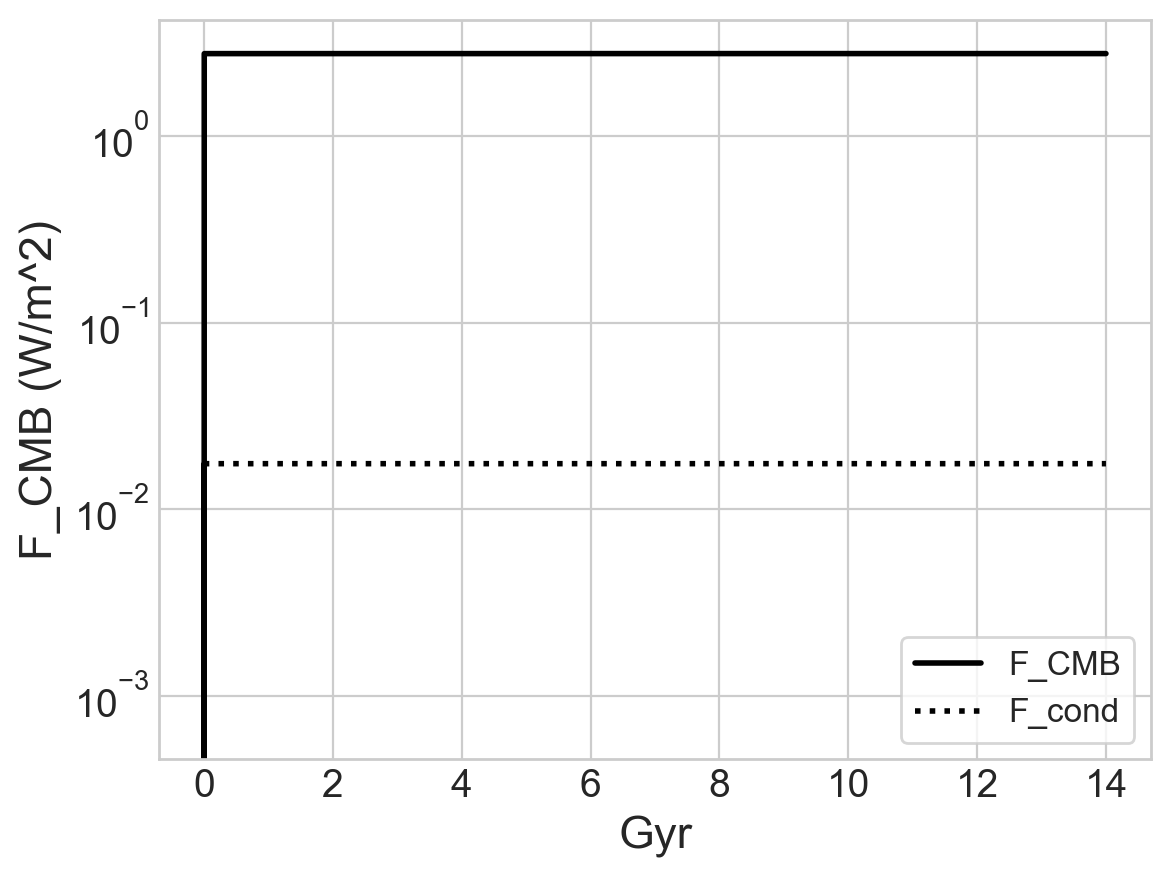

In [19]:
i_x=0
i_y=8
plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0,label='F_CMB')
i_y=9
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0,linestyle=':',label='F_cond')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('F_CMB (W/m^2)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 
plt.legend(frameon=True, fontsize=12)

Text(0.5, 0, 'Gyr')

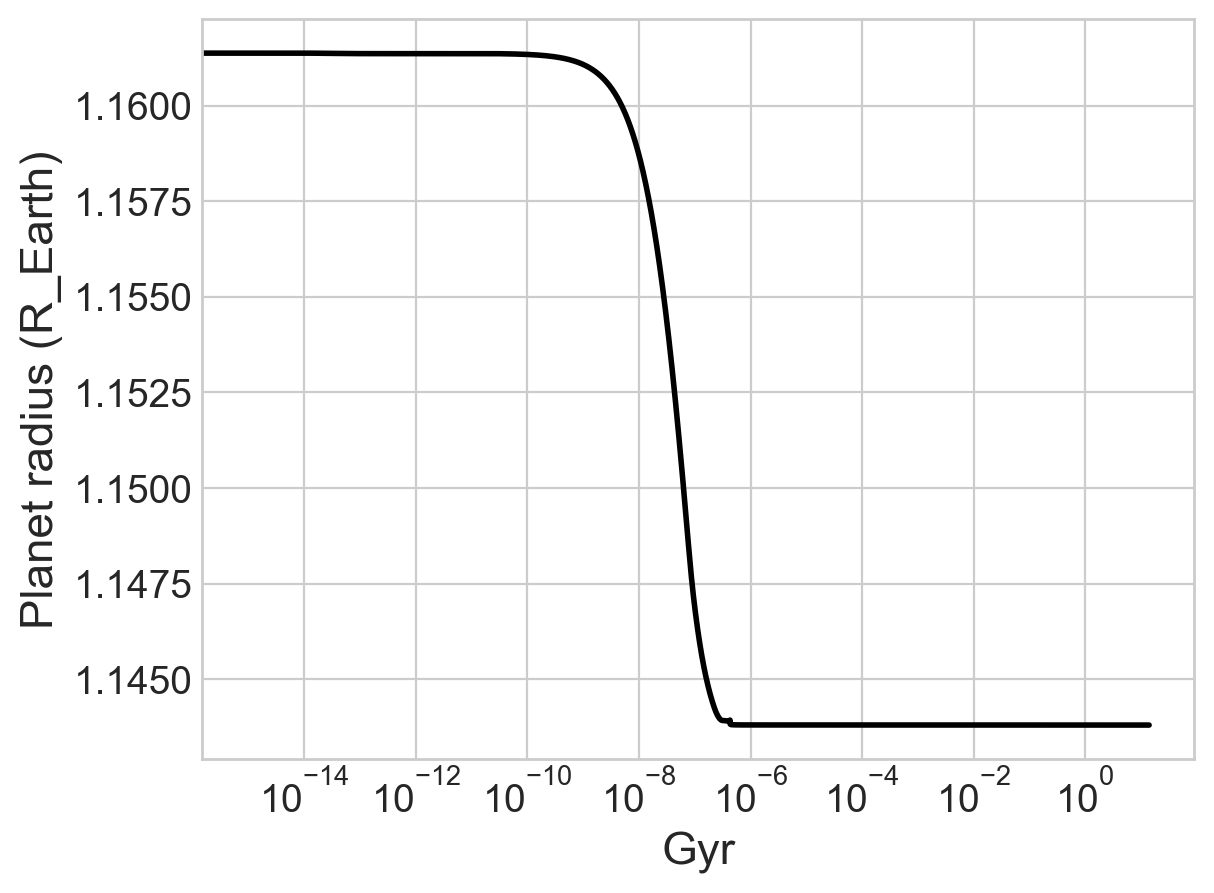

In [21]:
i_x=0
i_y=10
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/6371000.0,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Planet radius (R_Earth)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

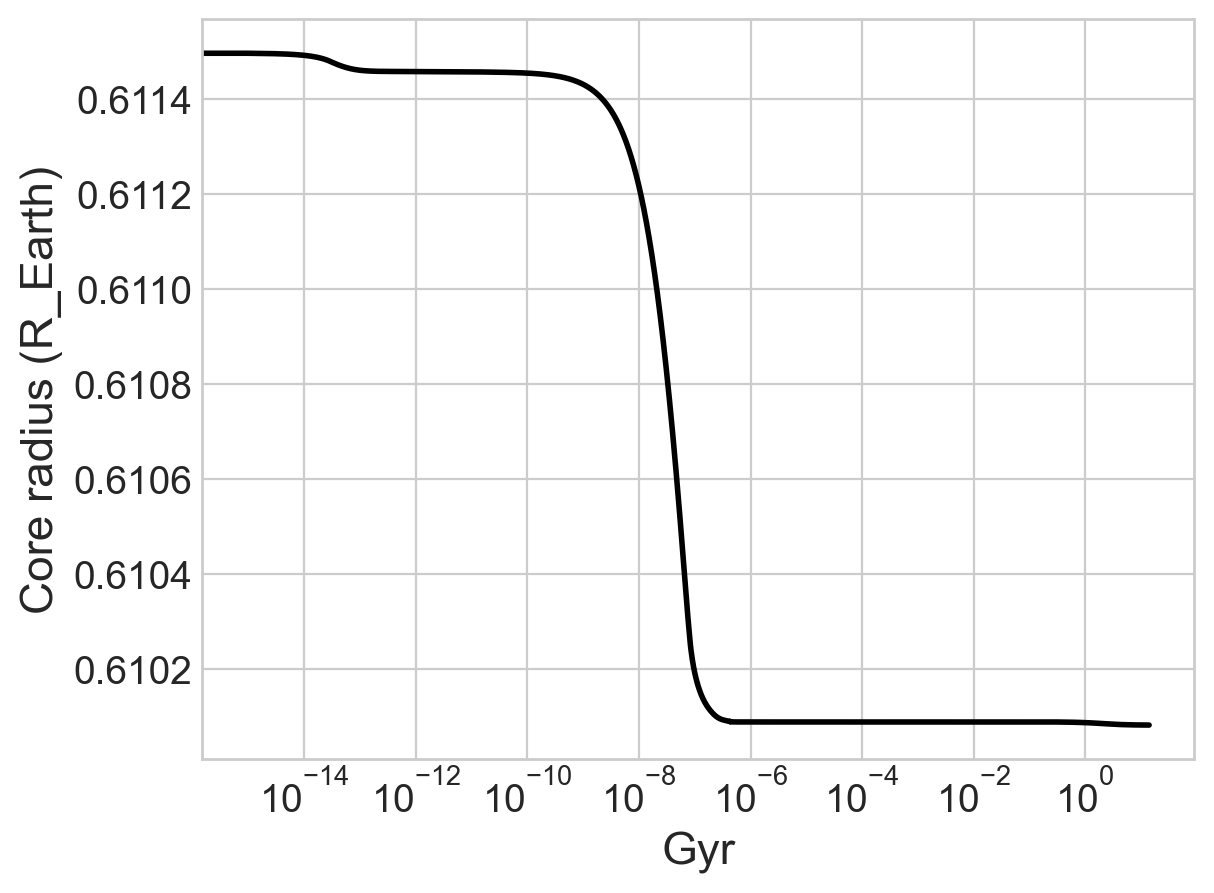

In [22]:
i_x=0
i_y=11
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/6371000.0,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Core radius (R_Earth)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

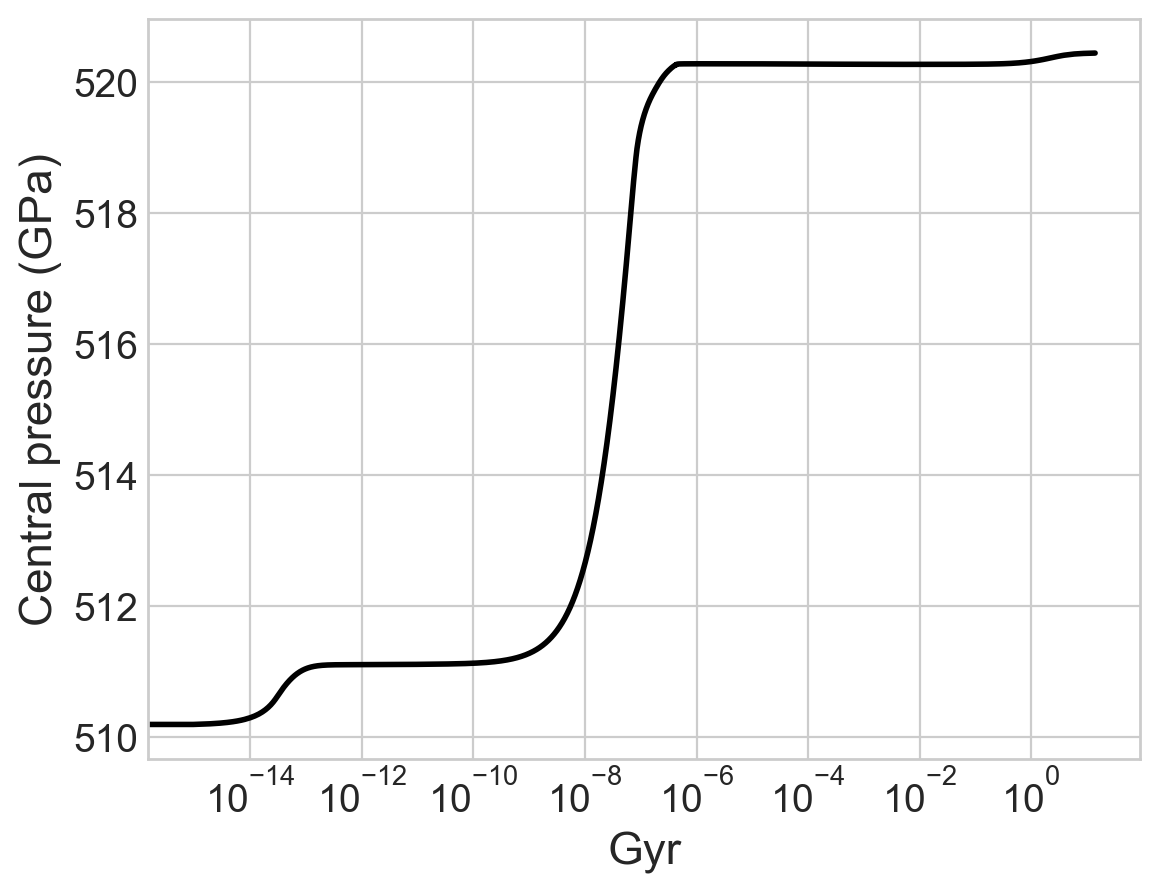

In [23]:
i_x=0
i_y=12
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/1e9,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Central pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

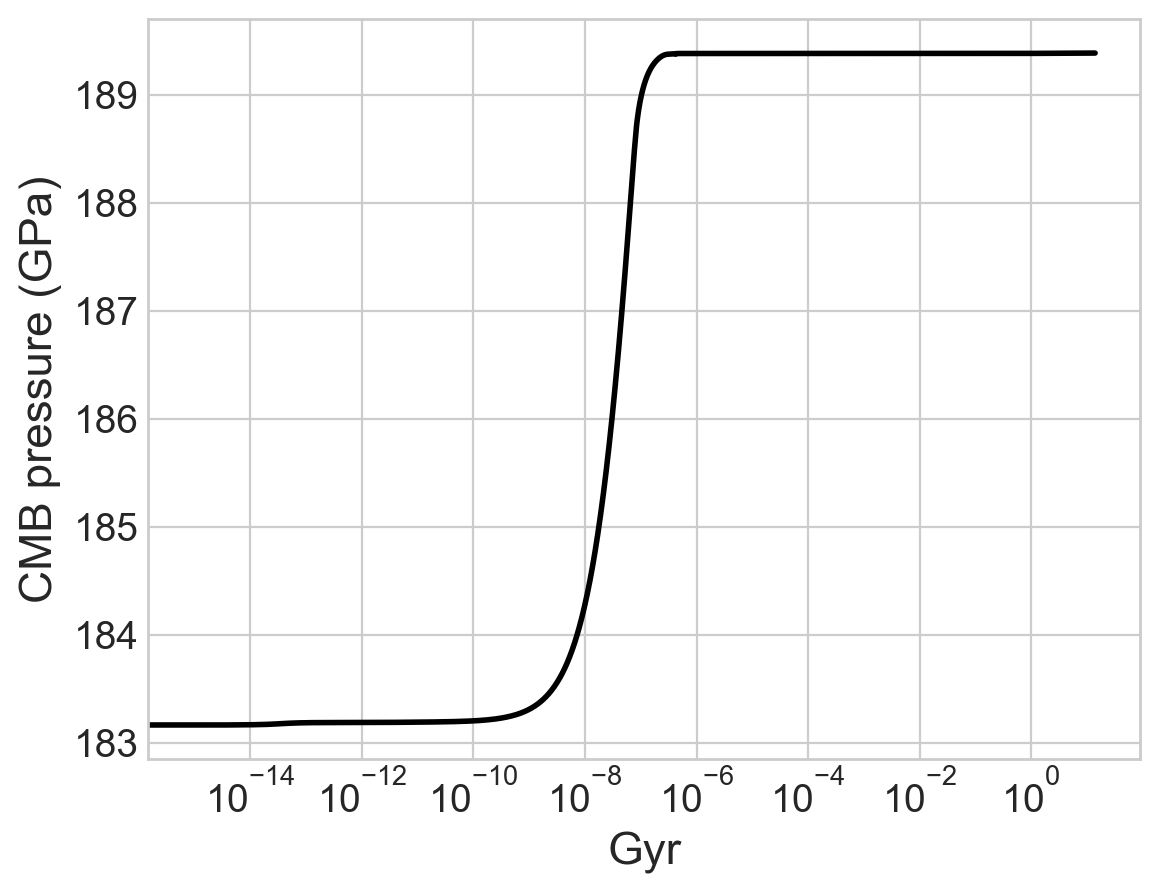

In [24]:
i_x=0
i_y=13
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/1e9,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('CMB pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

In [25]:
# timesteps (years) for which profiles are saved

save_t=[1.0]
for i in range(1,1000):
    if save_t[i-1]<10000.0:
        save_t.append(save_t[i-1]+20.0)
    elif save_t[i-1]<1e8:
        save_t.append(save_t[i-1]+int(save_t[i-1]/20.0))
    else:
        save_t.append(save_t[i-1]+int(save_t[i-1]/50.0))

In [26]:
ind=500 # select a timestep out of save_t
s=np.loadtxt('results/profile/structure_'+str(int(save_t[ind]))+'.txt')
p=np.loadtxt('results/profile/property_'+str(int(save_t[ind]))+'.txt')

### everything is in SI units.
####### s file 
# index   variable
# 0       radius
# 1       pressure
# 2       temperature
# 3       density
# 4       gravity
# 5       mass
####### p file
# index   variable
# 0       thermal expansion coefficient 
# 1       specific heat
# 2       gravity
# 3       Convective flux in the mantle
# 4       Convective velocity in the mantle
# 5       Magnetic Reynolds number
# 6.      viscosity

# pick i_x and i_y and s/p files to set x and y-axis in the following boxes to plot thermal and structural profiles

Text(0.5, 0, 'Gyr')

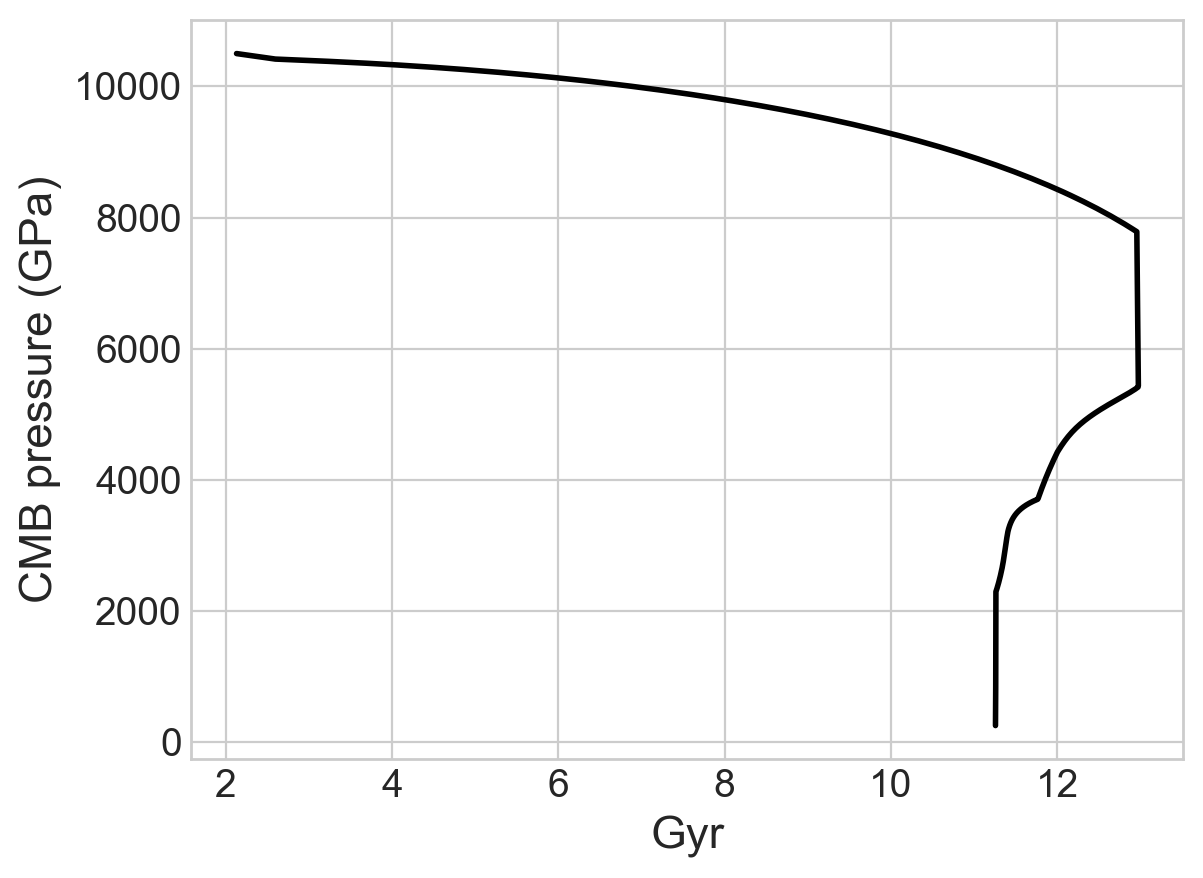

In [37]:
i_x=0
i_y=2
plt.plot(s[:,-1],s[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('CMB pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 